In [1]:
import sys
import cPickle as pickle
import gzip
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
np.random.seed(0)
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
train_set, _, _ = hp.load_mnist()

In [3]:
Xt, yt = train_set

In [4]:
yt = np.asarray(yt, dtype="int32")

In [11]:
l_in = InputLayer( (None, 1, 28, 28) )
l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(5,5), nonlinearity=rectify)
l_mp1 = MaxPool2DLayer(l_conv1, pool_size=(2,2))
l_conv2 = Conv2DLayer(l_mp1, num_filters=32, filter_size=(3,3), nonlinearity=rectify)
l_mp2 = MaxPool2DLayer(l_conv2, pool_size=(2,2))
l_out = DenseLayer(l_mp2, num_units=10, nonlinearity=softmax)

In [12]:
X = T.tensor4('X')
y = T.ivector('y')

In [33]:
lamb = 1e-3
loss = categorical_crossentropy( get_output(l_out, X), y ).mean() + \
    regularize_layer_params(l_out, l1) * lamb

In [34]:
params = get_all_params(l_out)
updates = nesterov_momentum(loss, params, 0.01, 0.9)

In [35]:
train_fn = theano.function([X, y], loss, updates=updates)

In [36]:
x_grad_fn = theano.function([X, y], T.grad(loss, X))

In [37]:
predict_fn = theano.function([X], get_output(l_out, X) )

In [9]:
Xt_9 = Xt[ (yt == 9) ]
yt_9 = np.asarray([9 for x in range(0, Xt_9.shape[0])], dtype="int32")

In [41]:
grads = []
for epoch in range(0, 10):
    b = 0
    batch_size = 32
    losses = []
    while True:
        if b*batch_size >= Xt.shape[0]:
            break
        this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
        losses.append(this_loss)
        b += 1
    print np.mean(losses)
    grads_for_9 = x_grad_fn(Xt_9, yt_9)
    mean_grads = np.mean(np.abs(grads_for_9), axis=0)
    grads.append(mean_grads)

0.211292923539
0.184147072141
0.170890121811
0.162622308174
0.156247477767
0.151752949919
0.148020442096
0.144896503671
0.142676430887


KeyboardInterrupt: 

In [127]:
with open("mean_grads.txt", "wb") as f:
    f.write( "\n".join([ str(x) for x in mean_grads.flatten().tolist() ]) )

Using $L1$ in combination with this technique? It will help with ranking the features because during the learning process, weights that correspond to useless pixels will be driven toward zero.

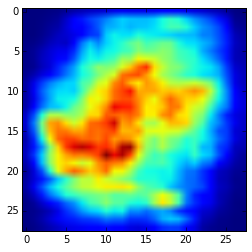

In [42]:
plt.imshow( (mean_grads)[-1] )

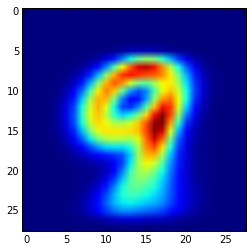

In [26]:
plt.imshow(np.mean(Xt_9, axis=0)[0])

In [32]:
l_conv1.W.get_value().flatten()

array([  8.67628089e-02,   1.62954237e-01,   7.35544757e-02,
        -6.90663897e-02,  -1.35198637e-01,   5.24805221e-02,
         5.07957820e-02,   2.15016859e-01,   1.93840346e-01,
        -1.99560921e-02,   5.48895227e-02,   1.08585559e-01,
         2.71898873e-01,   3.29319048e-01,  -5.15238037e-02,
        -5.51532876e-02,   8.07513615e-02,   4.09016159e-01,
         2.87455093e-01,   1.17792288e-01,   2.55242192e-01,
         2.87684270e-01,   1.71609116e-01,   1.67893207e-01,
        -8.18341799e-02,   9.43079552e-02,  -2.30905479e-02,
         8.56255243e-02,  -1.06101133e-01,  -1.41706814e-01,
         5.24943074e-03,   1.59193747e-01,   1.04173508e-01,
         7.87666939e-02,  -1.63171403e-01,   5.92148215e-04,
         7.95885073e-02,   2.07881658e-01,   3.47385706e-01,
         1.60961003e-01,  -1.55424416e-01,  -1.09563781e-01,
         6.35209182e-02,   5.36777035e-02,   1.90068848e-01,
        -1.09605641e-01,  -2.37610133e-01,  -2.34239727e-01,
        -7.67927157e-02,

In [140]:
with open("../data/mnist_pretrained.pkl", "wb") as f:
    pickle.dump(get_all_param_values(l_out), f, pickle.HIGHEST_PROTOCOL)

----

In [5]:
a_in = InputLayer( (None, 1, 28, 28) )
a_conv1 = Conv2DLayer(a_in, num_filters=32, filter_size=(5,5), nonlinearity=tanh)
a_mp1 = MaxPool2DLayer(a_conv1, pool_size=(2,2))
a_conv2 = Conv2DLayer(a_mp1, num_filters=64, filter_size=(3,3), nonlinearity=tanh)
a_mp2 = MaxPool2DLayer(a_conv2, pool_size=(2,2))
a_fc1 = DenseLayer(a_mp2, num_units=128)
# --
a_inv = InverseLayer(a_fc1, a_fc1)
a_inv2 = InverseLayer(a_inv, a_mp2)
a_inv3 = InverseLayer(a_inv2, a_conv2)
a_inv4 = InverseLayer(a_inv3, a_mp1)
a_inv5 = InverseLayer(a_inv4, a_conv1)

a_out = NonlinearityLayer(a_inv5, nonlinearity=sigmoid)

In [6]:
for layer in get_all_layers(a_out):
    print layer.output_shape
print count_params(a_out)

(None, 1, 28, 28)
(None, 32, 24, 24)
(None, 32, 12, 12)
(None, 64, 10, 10)
(None, 64, 5, 5)
(None, 128)
(None, 64, 5, 5)
(None, 64, 10, 10)
(None, 32, 12, 12)
(None, 32, 24, 24)
(None, 1, 28, 28)
(None, 1, 28, 28)
224256


In [7]:
X = T.tensor4('X')
y = T.ivector('y')

lamb = 0.0
loss = squared_error( get_output(a_out, X), X ).mean()

#regularize_layer_params(a_out, l1) * lamb
params = get_all_params(a_out)
updates = nesterov_momentum(loss, params, 0.01, 0.9)

train_fn = theano.function([X], loss, updates=updates)
x_grad_fn = theano.function([X], T.grad(loss, X))
predict_fn = theano.function([X], get_output(a_out, X) )
loss_fn = theano.function([X], loss )

In [8]:
grads = []
for epoch in range(0, 5):
    b = 0
    batch_size = 128
    losses = []
    while True:
        if b*batch_size >= Xt.shape[0]:
            break
        this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size])
        losses.append(this_loss)
        b += 1
    print np.mean(losses)

0.176138797857


KeyboardInterrupt: 

In [11]:
grads = x_grad_fn(Xt_9)

In [12]:
grads.shape

(4988, 1, 28, 28)

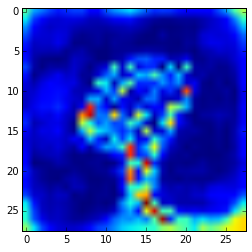

In [37]:
plt.imshow(np.mean(np.abs(grads[0:1]), axis=0)[0])

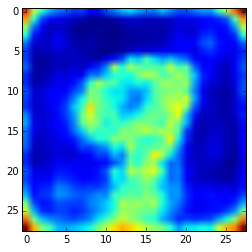

In [38]:
plt.imshow(np.mean(np.abs(grads), axis=0)[0])

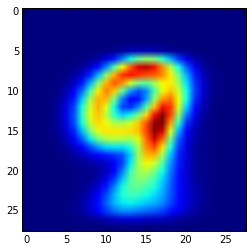

In [23]:
plt.imshow(np.mean(Xt_9, axis=0)[0])

Reconstruction error.

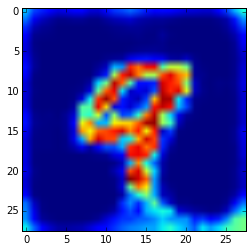

In [28]:
plt.imshow( predict_fn(Xt_9[0:1])[0][0] )

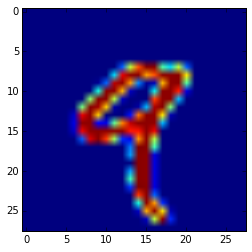

In [29]:
plt.imshow( Xt_9[0:1][0][0] )

----

In [2]:
from scipy.io import loadmat

In [3]:
data = loadmat("../data/20news_w100.mat")

In [4]:
X_total = data["documents"].toarray().T

In [5]:
X_total = np.asarray(X_total, dtype="float32")

In [6]:
X_total.shape

(16242, 100)

In [36]:
X_noise = np.random.randint(10, 11, (X_total.shape[0], X_total.shape[1]))
X_noise = np.asarray(X_noise, dtype="float32")

In [37]:
X = T.fmatrix('X')
y = T.fmatrix('y')

In [38]:
grads = []

X_total_stack = np.hstack( (X_total, X_noise) )

for tp in [(X_total_stack, X_total_stack), (X_noise, X_total)]:
    
    X_data, y_data = tp
    print X_data.shape, y_data.shape

    print "training..."
    
    b_in = InputLayer( (None, X_data.shape[1]) )
    b_hidden = DenseLayer(b_in, num_units=50, nonlinearity=rectify)
    b_hidden2 = DenseLayer(b_hidden, num_units=25, nonlinearity=rectify)
    b_hidden3 = DenseLayer(b_hidden2, num_units=5, nonlinearity=rectify)
    b_hidden4 = InverseLayer(b_hidden3, b_hidden3)
    b_hidden5 = InverseLayer(b_hidden4, b_hidden2)
    b_out = InverseLayer(b_hidden5, b_hidden)

    lamb = 0
    loss = squared_error( get_output(b_out, X), y ).mean() + \
        regularize_layer_params(b_out, l1) * lamb
    params = get_all_params(b_out)
    #updates = nesterov_momentum(loss, params, 0.01, 0.9)
    updates = rmsprop(loss, params, 0.01)

    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(b_out, X) )
    loss_fn = theano.function([X, y], loss )

    for epoch in range(0, 20):
        b = 0
        batch_size = 128
        losses = []
        while True:
            if b*batch_size >= X_data.shape[0]:
                break
            this_loss = train_fn(
                X_data[b*batch_size : (b+1)*batch_size], y_data[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        print np.mean(losses)
        
    grads.append( x_grad_fn(X_data, y_data) )

(16242, 200) (16242, 200)
training...
6.03570362697
1.20527070755
0.737655763345
0.657691345715
0.610691811577
0.592982397801
0.567514684901
0.535280121607
0.479805457208
0.433316442776
0.400569245053
0.375740180407
0.37146291817
0.369358456242
0.365548044269
0.363796104803
0.360257511781
0.358684551846
0.355286398556
0.353751981344
(16242, 100) (16242, 100)
training...
0.167760775408
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391
0.0402984053391


In [39]:
good_grads = np.mean(np.abs(grads[0]),axis=0)
noise_grads = np.mean(np.abs(grads[1]),axis=0)
print good_grads.shape, noise_grads.shape

(200,) (100,)


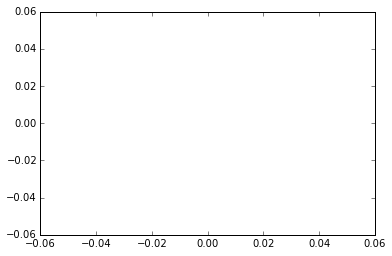

In [40]:
plt.plot(noise_grads / np.sum(noise_grads))

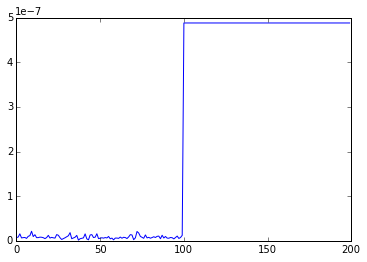

In [41]:
plt.plot(np.abs(grads[0][0]))

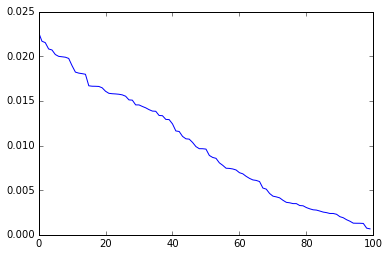

In [329]:
plt.plot(np.sort(good_grads)[::-1] / np.sum(good_grads))

In [288]:
np.argsort(good_grads)

array([28, 53, 13, 44, 38, 56, 20, 36,  1, 89, 91, 67, 43, 40, 63, 92, 81,
       98, 54, 48, 42, 83, 23, 62, 78, 55, 27, 47, 94, 58, 35,  6, 75, 95,
       86, 16, 12,  3, 15, 41, 17, 74, 61,  4, 59,  8, 76, 57, 64, 71, 80,
       14, 21, 68, 29, 49,  0, 96, 70, 19,  7, 26, 34, 30, 93, 73, 39, 79,
       65, 77, 18, 24, 50, 46, 66, 51, 52, 84, 88, 31, 97, 10,  5,  2, 45,
       87, 85, 33, 11, 99,  9, 60, 82, 37, 32, 90, 25, 72, 22, 69])

In [315]:
attr_names = [ elem[0] for elem in data["wordlist"][0] ]
attr_names[0:10]

[u'aids',
 u'baseball',
 u'bible',
 u'bmw',
 u'cancer',
 u'car',
 u'card',
 u'case',
 u'children',
 u'christian']

In [320]:
attr_names[69]

u'problem'